<a href="https://colab.research.google.com/github/amsaghiri/Goore-Game/blob/main/ICAP_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

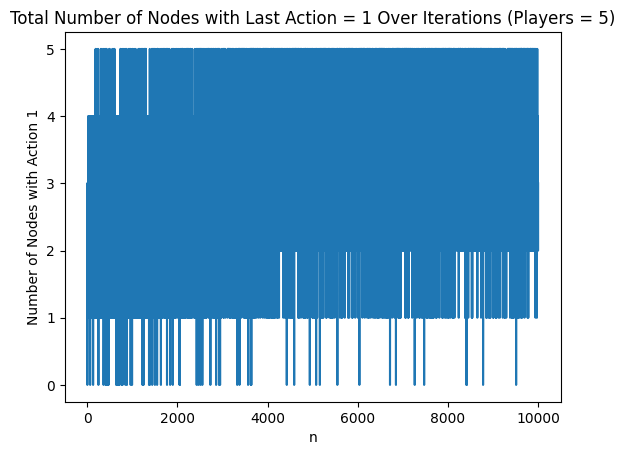

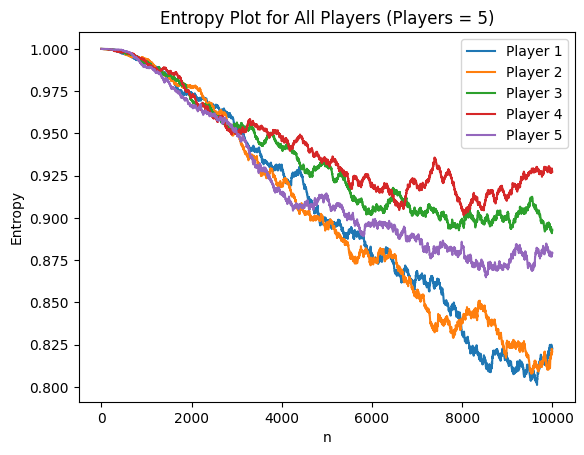

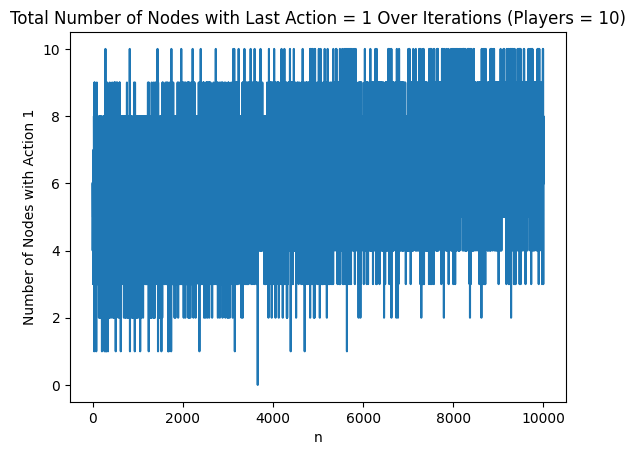

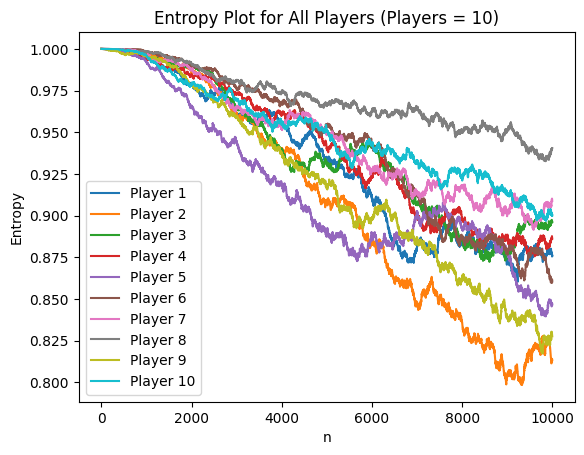

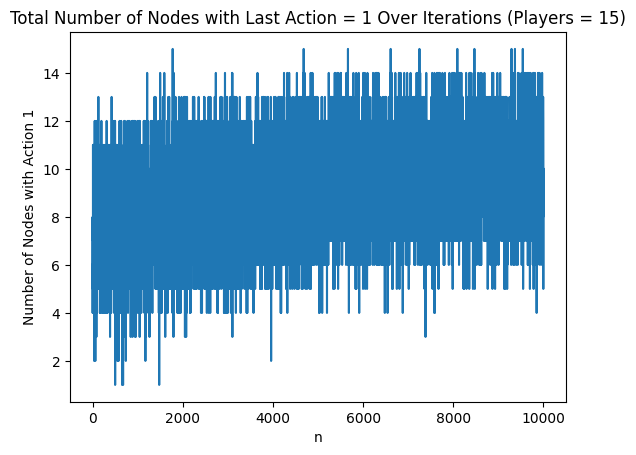

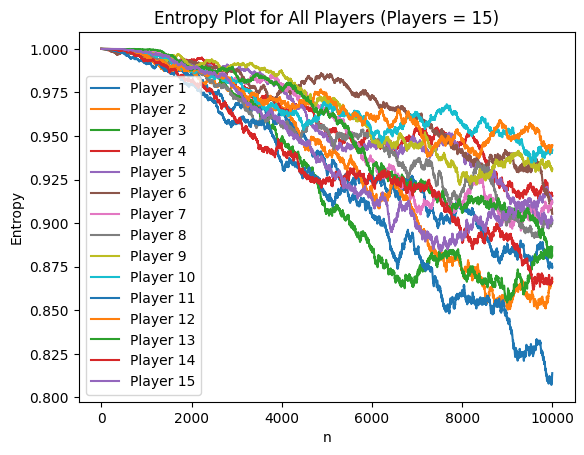

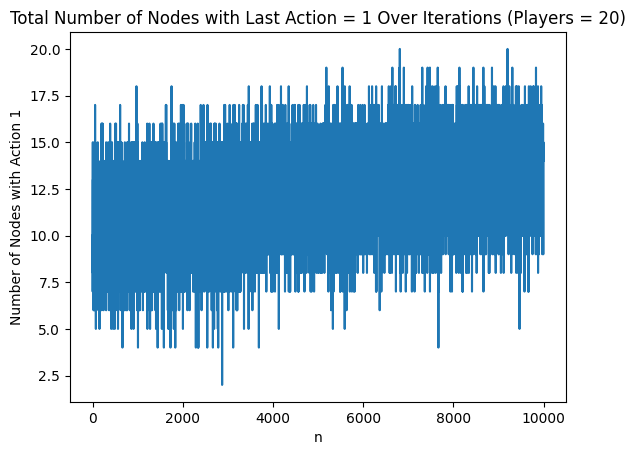

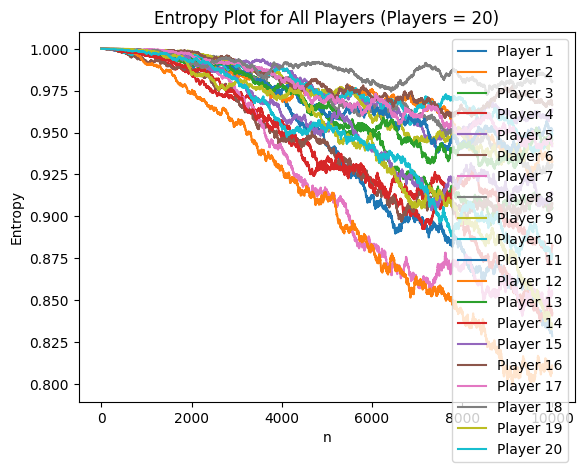

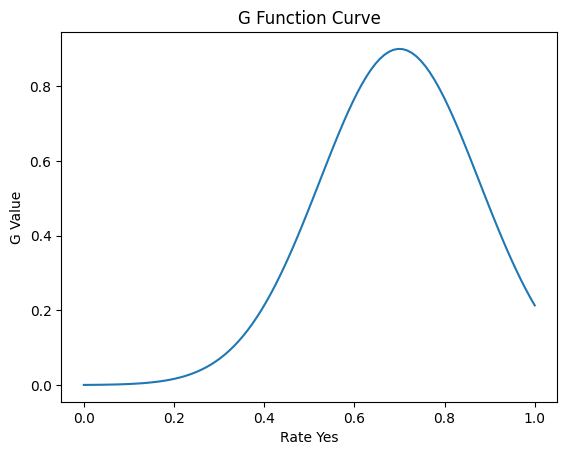

In [24]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random
from typing import List
import pandas as pd

class Automata:
    def __init__(self, r, lambda_1, lambda_2):
        self.r = int(r)
        self.lambda_1 = lambda_1
        self.lambda_2 = lambda_2
        if (r == 0):
            raise ValueError("Must have at least one action.")
        self.probability_list = [1 / self.r for x in range(self.r)]
        self.action_selected_list = []
        self.action_last = -1
        self.entropy_list = []
        self.favor_action_list = []
        self.reward_history=[]
    def set_probability_list(self,probability_list):
        if len(probability_list)==self.r:
            self.probability_list = probability_list

    def decision(self):
        random_value = random.uniform(0, 1)
        if(random_value<self.probability_list[0]):
            self.action_last=1
        else:
            self.action_last=2
        # self.action_last = np.random.choice(np.arange(1, self.r + 1), 1, self.probability_list)[0]
        self.action_selected_list.append(self.action_last)
        self.favor_action_list.append(self.cal_probablable_action())
        self.entropy_list.append(self.cal_entropy())
        return self.action_last

    def update(self, B):
        if(B==1):
            if(self.action_last ==1):
                p=self.probability_list[0]
                self.probability_list[0]= p + (self.lambda_1  * (1 - p))
                self.probability_list[1]= 1-self.probability_list[0]
            if(self.action_last ==2):
                p=self.probability_list[1]
                self.probability_list[1]= p + (self.lambda_1  * (1 - p))
                self.probability_list[0]= 1-self.probability_list[1]

    def cal_entropy(self):
        entropy = 0
        for index in range(len(self.probability_list)):
            p = self.probability_list[index]
            entropy += -1 * math.log(p,self.r) * p
        return entropy

    def cal_probablable_action(self):
        return [i for i, j in enumerate(self.probability_list) if j == max(self.probability_list)][0] + 1

class Environment:
    def __init__(self, r):
        self.r = r
        self.probability_list = []

    def get_reward(self, rate_yes):
        # probability for get reward
        # G=0.9e-[(0.7-x)*(0.7-x)/0.0625]
        G = 0.9 * math.exp(-((0.7 - rate_yes) * (0.7 - rate_yes) / 0.0625))
        random_value = random.uniform(0, 1)
        if (random_value < G):
            return 1
        return 0
    def get_reward_custom(self, action_list):
        if action_list==[2,2,1,2,1,2,1,2,2,2]:
            return 1
        return 0
    def get_reward_custom1(self, rate_yes):
        if rate_yes == 0.7:
            return 1
        return 0

class Node:
    def __init__(self, automatas: List[Automata], id: int):
        self.automata_list = automatas
        self.id = id

class Graph:
    def __init__(self, initial_node_list: List[Node]):
        self.node_list = initial_node_list
    def add_node(self,node):
        self.node_list.append(node)
    def get_nodes(self):
        return self.node_list

# setting
num_iteration = 10000
r = 2
lambda_1 = 0.001
lambda_2 = 0

number_players_list = [5, 10, 15, 20]

for number_players in number_players_list:
    rate_yes_list = []
    environment = Environment(r)
    graph = Graph([])
    def probability_players(i):
        switcher = {
            0: [0.5, 0.5],
            1: [0.5, 0.5],
            2: [0.5, 0.5],
            3: [0.5, 0.5],
            4: [0.5, 0.5],
            5: [0.5, 0.5],
            6: [0.5, 0.5],
            7: [0.5, 0.5],
            8: [0.5, 0.5],
            9: [0.5, 0.5],
        }
        return switcher.get(i, [0.5, 0.5])

    for i in range(number_players):
        automata_instance = Automata(r, lambda_1, lambda_2)
        automata_instance.set_probability_list(probability_players(i))
        node = Node([automata_instance], i + 1)
        graph.add_node(node)

    # Play scenario
    index_num_iteration = 0
    nodes_action_1_count = []

    while index_num_iteration < num_iteration:
        action_selected_list = []
        rate_yes = 0
        count_action_1 = 0
        for node in graph.get_nodes():
            action_selected = node.automata_list[0].decision()
            action_selected_list.append(action_selected)
            if action_selected == 1:
                rate_yes += 1
                count_action_1 += 1
        rate_yes = float(rate_yes / number_players)
        rate_yes_list.append(rate_yes)
        nodes_action_1_count.append(count_action_1)
        # Get reward
        for node in graph.get_nodes():
            reward = environment.get_reward(rate_yes)
            # reward = environment.get_reward_custom(action_selected)
            node.automata_list[0].reward_history.append(reward)
            node.automata_list[0].update(reward)
        index_num_iteration += 1

    # Plotting the total number of nodes whose last action is 1 over iterations
    plt.figure()
    plt.plot(np.arange(0, num_iteration), nodes_action_1_count)
    plt.title(f'Total Number of Nodes with Last Action = 1 Over Iterations (Players = {number_players})')
    plt.xlabel('n')
    plt.ylabel('Number of Nodes with Action 1')
    plt.savefig(f'nodes_action_1_count_plot_players_{number_players}.png')
    plt.show()

    # Plotting the entropy for each player
    plt.figure()
    for node in graph.get_nodes():
        automata_instance = node.automata_list[0]
        plt.plot(np.arange(0, num_iteration), automata_instance.entropy_list, label=f'Player {node.id}')

    # Adding title and labels for the combined entropy plot
    plt.title(f'Entropy Plot for All Players (Players = {number_players})')
    plt.xlabel('n')
    plt.ylabel('Entropy')
    plt.legend()
    plt.savefig(f'combined_entropy_plot_players_{number_players}.png')
    plt.show()

# Plotting the G function over rate_yes values
rate_yes_values = np.linspace(0, 1, 100)
G_values = [0.9 * math.exp(-((0.7 - rate_yes) * (0.7 - rate_yes) / 0.0625)) for rate_yes in rate_yes_values]

plt.figure()
plt.plot(rate_yes_values, G_values)
plt.title('G Function Curve')
plt.xlabel('Rate Yes')
plt.ylabel('G Value')
plt.savefig('g_function_plot.png')
plt.show()
